In [6]:
import numpy as np
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm
import sys
sys.path.insert(1, '../src')

from model import DeepONet
from wave_loader import *

path = '../'

In [2]:
paths = glob('../data/10/*.npy')
ds_train, ds_valid = get_wave_datasets(paths)

In [18]:
# Convergence test
model = DeepONet(10, 128, 128)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=1-1e-3)
epochs = 1000
batch_size = 10
loss_function = torch.nn.MSELoss()

epoch_train_losses = []
epoch_validation_losses = []

train_dataloader = DataLoader(ds_train, batch_size=10, shuffle=True)
validation_dataloader = DataLoader(ds_valid, batch_size=10, shuffle=True)

In [20]:
for epoch in range(epochs):
    train_losses = []

    for (xt_batch, y_batch, u_batch) in train_dataloader:
        optimizer.zero_grad()
        # Forward pass through network
        pred = model(u_batch, xt_batch)
        loss = loss_function(pred, y_batch.view(-1))
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

    epoch_train_losses.append(np.mean(train_losses))
    lr_scheduler.step()

    if epoch % 10 == 0:
        # Do validation
        validation_losses = []
        model.eval()
        for (xt_batch, y_batch, u_batch) in validation_dataloader:
            pred = model(u_batch, xt_batch)
            loss = loss_function(pred, y_batch.view(-1))
            validation_losses.append(loss.item())

        epoch_validation_losses.append(np.mean(validation_losses))
        model.train()
        # Print train and validation loss
        print(f'Epoch {epoch} train loss: {epoch_train_losses[-1]} validation loss: {epoch_validation_losses[-1]}')
        

Epoch 0 train loss: 3.494522453844547 validation loss: 9.5248615026474
Epoch 10 train loss: 0.171142866788432 validation loss: 20.653635120391847
Epoch 20 train loss: 0.19978678841143846 validation loss: 17.61303369998932
Epoch 30 train loss: 0.10401078786235303 validation loss: 17.523541010916233
Epoch 40 train loss: 0.1441528988070786 validation loss: 16.233077359199523
Epoch 50 train loss: 0.1292217559996061 validation loss: 10.151064991950989
Epoch 60 train loss: 0.07114296450745314 validation loss: 10.455643835663796
Epoch 70 train loss: 0.08278031557565554 validation loss: 12.048981940746307
Epoch 80 train loss: 0.08755655642598867 validation loss: 9.74364413022995
Epoch 90 train loss: 0.05192411023017485 validation loss: 9.151518666744233
Epoch 100 train loss: 0.08564013668801636 validation loss: 8.12056542634964
Epoch 110 train loss: 0.10510154264047741 validation loss: 7.18827648460865
Epoch 120 train loss: 0.08086495494935661 validation loss: 4.634223257005215
Epoch 130 train

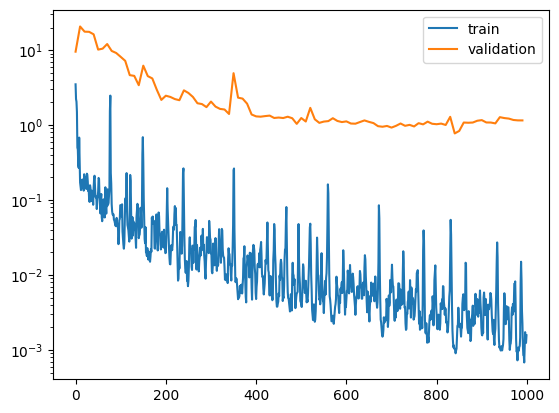

In [23]:
# Log Plot train and validation loss
plt.semilogy(np.arange(0, epochs, 1), epoch_train_losses, label='train')
plt.semilogy(np.arange(0, epochs, 10), epoch_validation_losses, label='validation')
plt.legend()
plt.show()

Try and predict trajectories of an initial condition included in the training set.

In [24]:
xts = ds_train[:][0]
ys = ds_train[:][1]
us = ds_train[:][2]

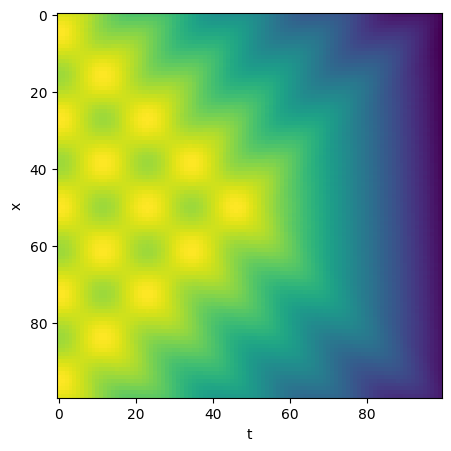

In [25]:
test = np.load('../data/10/0.npy', allow_pickle=True)
xs = test[0][0]
ts = test[0][1]
ys = test[0][2]
us = test[0][3]

fig, ax = plt.subplots(1, figsize=(5,5))
ax.set_xlabel('t')
ax.set_ylabel('x')
ax.imshow(ys)

plt.show()


In [26]:
XT = np.meshgrid(xs, ts)
trunk_input = torch.from_numpy(np.vstack([XT[0].ravel(), XT[1].ravel()]).T).float()
branch_input = torch.from_numpy(us).float()

In [27]:
model.set_batch(False)
deep_output = np.zeros_like(ys)
for i, xt in enumerate(trunk_input):
    j = i // 100
    deep_output[i % 100, j] = model(branch_input, xt)

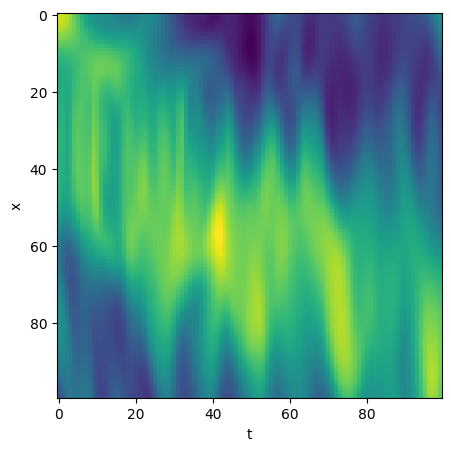

In [28]:
fig, ax = plt.subplots(1, figsize=(5,5))
ax.set_xlabel('t')
ax.set_ylabel('x')
ax.imshow(deep_output)

plt.show()

# Conclusion
We are unable to predict trajectories with the training data of 10 sensors and a limited amount of data, but the model passes convergence test as training error is reducing. 